In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
import cftime
import datetime
from datetime import date
from matplotlib import pyplot
from matplotlib import colors
from matplotlib import font_manager
from matplotlib.cm import ScalarMappable
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
import numpy
import pandas
from PIL import Image
import random
import xarray as xr

In [2]:
Diri = '/glade/u/home/whimkao//ExtraTrack/ExtraTrack_Data/Output_Files_V6/'
Output_Diri = '/glade/u/home/whimkao//ExtraTrack/ExtraTrack_Github/RCP_Figs/Analysis_Figs_V6.3.1/'

In [3]:
# Open File
def Open_File(File):
    DF = pandas.read_csv(File)
    DF = DF.drop("Unnamed: 0", axis=1)
    return (DF)

In [4]:
# Open Each File
def Files_Open(Model, Diri, Subset):
    Data_DF = Open_File(Diri+Model+'_Data_'+Subset+'_Output_V6.csv')
    ET_DF = Open_File(Diri+Model+'_ET_'+Subset+'_Output_V6.csv')
    Codes_DF = Open_File(Diri+Model+'_Codes_Output_V6.csv')
# Edit Time Format
    Time, Begin_Time, Compl_Time, Trop_Peak_Time, Peak_Time, Birth_Time = [], [], [], [], [], []
    for i in range(len(Data_DF)):
        Time.append(Datetime(Data_DF["Time(Z)"][i]))
    for j in range(len(ET_DF)):
        Begin_Time.append(Datetime(ET_DF["ET Begin Time"][j]))
        Compl_Time.append(Datetime(ET_DF["ET Complete Time"][j]))
        Trop_Peak_Time.append(Datetime(ET_DF["Trop Peak Time"][j]))
        Peak_Time.append(Datetime(ET_DF["Peak Time"][j]))
        Birth_Time.append(Datetime(ET_DF["Genesis Time"][j]))
    Data_DF["Time(Z)"] = Time
    ET_DF["ET Begin Time"] = Begin_Time
    ET_DF["ET Complete Time"] = Compl_Time
    ET_DF["Trop Peak Time"] = Trop_Peak_Time
    ET_DF["Peak Time"] = Peak_Time
    ET_DF["Genesis Time"] = Birth_Time
    return (Data_DF, ET_DF, Codes_DF)

In [5]:
def Datetime(Time):
    try:
        New_Time = datetime.datetime.strptime(Time, '%Y-%m-%d %H:%M:%S')
    except:
        New_Time = numpy.nan
    return (New_Time)

In [6]:
# Create Phase Distribution Bins
def Create_Bins(Min, Max, Bin_Width):
    Bins = numpy.arange(Min, Max+Bin_Width, Bin_Width)
    return (Bins)
VLT_Bins = Create_Bins(-600,600,50)
B_Bins = Create_Bins(-45,135,7.5)
VUT_Bins = Create_Bins(-600,600,50)
Bins_Bounds = numpy.array([-600,600,50,-45,135,7.5])

In [7]:
Num_Years = numpy.array([90,93,93])

In [8]:
Control_Data, Control_ET, Control_Codes = Files_Open("Control", Diri, "SubsetB")
RCP45_Data, RCP45_ET, RCP45_Codes = Files_Open("RCP45", Diri, "SubsetB")
RCP85_Data, RCP85_ET, RCP85_Codes = Files_Open("RCP85", Diri, "SubsetB")

In [9]:
# Create Function to Calculate Phase Space Distribution
def Phase_Space_Distr(DF, VLT_Bins, B_Bins, VUT_Bins, Model):
    Length = len(DF)
    VLT_B_Count = numpy.zeros((len(VLT_Bins)-1, len(B_Bins)-1))
    VLT_VUT_Count = numpy.zeros((len(VLT_Bins)-1, len(VUT_Bins)-1))
#
# Count Phase Space Distribution
    Params_VLT = Create_Bins(0,40,10)
    Params_B = Create_Bins(0,5,1.25)
    Params_VUT = Create_Bins(0,40,10)
    for j in range(len(VLT_Bins)-1):
        for k in range(len(B_Bins)-1):
            VLT_B_Count[j][k] = Phase_Space_Count(DF, "VLT", "B", VLT_Bins[j], VLT_Bins[j+1], \
            B_Bins[k], B_Bins[k+1], Params_VLT, Params_B, True)
        for l in range(len(VUT_Bins)-1):
            VLT_VUT_Count[j][l] = Phase_Space_Count(DF, "VLT", "VUT", VLT_Bins[j], VLT_Bins[j+1], \
            VUT_Bins[l], VUT_Bins[l+1], Params_VLT, Params_VUT, True)
#
# Calculate Phase Space Density
    VLT_B_Density = VLT_B_Count / numpy.sum(VLT_B_Count) * 1000
    VLT_VUT_Density = VLT_VUT_Count / numpy.sum(VLT_VUT_Count) * 1000
    return (VLT_B_Density, VLT_VUT_Density)

In [10]:
# Count Phase Space Distribution
def Phase_Space_Count(DF, x_Var, y_Var, x_Min, x_Max, y_Min, y_Max, Params_x, Params_y, Zero):
    if Zero == False:
        Count_Total = 0
        for m in range(len(Params_x)):
            for n in range(len(Params_y)):
                Param_x, Param_y = Params_x[m], Params_y[n]
                Subset = DF[(DF[x_Var] >= x_Min-Param_x) & (DF[x_Var] <= x_Max+Param_x) &
                (DF[y_Var] >= y_Min-Param_y) & (DF[y_Var] <= y_Max+Param_y)]
                Count = len(Subset)
                Count_Total += Count
        Count_Final = Count_Total / (len(Params_x) * len(Params_y))
    elif Zero == True:
        Subset = DF[(DF[x_Var] >= x_Min) & (DF[x_Var] <= x_Max) &
        (DF[y_Var] >= y_Min) & (DF[y_Var] <= y_Max)]
        Count = len(Subset)
        if Count > 0:
            Count_Total = 0
            for m in range(len(Params_x)):
                for n in range(len(Params_y)):
                    Param_x, Param_y = Params_x[m], Params_y[n]
                    Subset = DF[(DF[x_Var] >= x_Min-Param_x) & (DF[x_Var] <= x_Max+Param_x) &
                    (DF[y_Var] >= y_Min-Param_y) & (DF[y_Var] <= y_Max+Param_y)]
                    Count = len(Subset)
                    Count_Total += Count
            Count_Final = Count_Total / (len(Params_x) * len(Params_y))
        else:
            Count_Final = 0
    return (Count_Final)

In [11]:
# Calculate Percentage of Points in Each Quadrant
def Phase_Space_Quadrant(Density_1000, Var):
    Density = Density_1000 / 1000
    x_Length = len(Density)
    y_Length = len(Density[0])
    x_Mid = int(x_Length / 2)
    Right_Half = Density[x_Mid:]
    Left_Half = Density[:x_Mid]
    Q1, Q2, Q3, Q4 = 0, 0, 0, 0
    if Var == "VUT":
        y_Mid = int(y_Length / 2)
    elif Var == "B":
        y_Mid = int(y_Length / 3)
    for i in range(len(Right_Half)):
        Top_Right = numpy.sum(Right_Half[i][y_Mid:])
        Q1 += Top_Right
        Bottom_Right = numpy.sum(Right_Half[i][:y_Mid])
        Q4 += Bottom_Right
    for j in range(len(Left_Half)):
        Top_Left = numpy.sum(Left_Half[j][y_Mid:])
        Q2 += Top_Left
        Bottom_Left = numpy.sum(Left_Half[j][:y_Mid])
        Q3 += Bottom_Left
    return (numpy.array([Q1, Q2, Q3, Q4]))

In [12]:
# Plot Cyclone Phase Distribution
def Phase_Distr_Plot(DF, Model, i, Bounds, Colours, Colourbar, Subset):
# Use Function to Calculate Distributions
    VLT_B, VLT_VUT = Phase_Space_Distr(DF, VLT_Bins, B_Bins, VUT_Bins, Model)
#
# VLT B Distribution
    Axis = Fig.add_subplot(3,2,i*2+1)
    for j in range(len(VLT_B)):
        for k in range(len(VLT_B[0])):
            Colour = Distr_Colour(VLT_B[j][k], Colours, Bounds)
            pyplot.fill_between([VLT_Bins[j],VLT_Bins[j+1]], B_Bins[k], B_Bins[k+1], color=Colour)
    Phase_Distr_Formatting("B", Model, Axis, Subset)
# Add Quadrant Percent
    Quadrant_Percent = Phase_Space_Quadrant(VLT_B, "B")
    xloc = [0.88,0.12,0.12,0.88]
    yloc = [0.88,0.88,0.12,0.12]
    for q in range(len(Quadrant_Percent)):
        Axis.text(xloc[q], yloc[q], str('%5.3f' % Quadrant_Percent[q]), ha='center', va='center', \
        transform=Axis.transAxes, fontdict={'size':28},color='black')
    Letter_Label(Axis, i*2)
#
# VLT VUT Distribution
    Axis = Fig.add_subplot(3,2,i*2+2)
    for j in range(len(VLT_VUT)):
        for l in range(len(VLT_VUT[0])):
            Colour = Distr_Colour(VLT_VUT[j][l], Colours, Bounds)
            pyplot.fill_between([VLT_Bins[j],VLT_Bins[j+1]], VLT_Bins[l], VLT_Bins[l+1], color=Colour)
    Phase_Distr_Formatting("VUT", Model, Axis, Subset)
# Add Quadrant Percent
    Quadrant_Percent = Phase_Space_Quadrant(VLT_VUT, "VUT")
    xloc = [0.88,0.12,0.12,0.88]
    yloc = [0.88,0.88,0.12,0.12]
    for q in range(len(Quadrant_Percent)):
        Axis.text(xloc[q], yloc[q], str('%5.3f' % Quadrant_Percent[q]), ha='center', va='center', \
        transform=Axis.transAxes, fontdict={'size':28},color='black')
    Letter_Label(Axis, i*2+1)
#
# Colour Bar
    if Colourbar == True:
        Cbar_Label = 'Density (Per 1000 Data Points)'
        C_Map = mcolors.LinearSegmentedColormap.from_list("Density (10^-3)", Colours, N=len(Colours))
        Norm = mcolors.BoundaryNorm(Bounds, C_Map.N, extend='max')
        Cax = Axis.inset_axes([-0.6, -0.085, 1, 0.03], transform=Axis.transAxes)
        Fig.colorbar(ScalarMappable(cmap=C_Map, norm=Norm), orientation='horizontal', cax=Cax, \
        label=Cbar_Label, ticks=Bounds, shrink=0.7)

In [13]:
# Formatting For Cyclone Phase Distribution Plot
def Phase_Distr_Formatting(y_Var, Model, Axis, Subset):
    x_Axis = Create_Bins(Bins_Bounds[0],Bins_Bounds[1],100)
    pyplot.xlim(Bins_Bounds[0],Bins_Bounds[1])
    if y_Var == "B":
        y_Axis = Create_Bins(Bins_Bounds[3],Bins_Bounds[4],15)
        pyplot.ylim(Bins_Bounds[3],Bins_Bounds[4])
        pyplot.plot([-1000,1000], [15,15], 'black', linewidth=0.5)
        pyplot.plot([0,0], [-150,300], 'black', linewidth=0.5)
    else:
        y_Axis = Create_Bins(Bins_Bounds[0],Bins_Bounds[1],100)
        pyplot.ylim(Bins_Bounds[0],Bins_Bounds[1])
        pyplot.plot([-1000,1000], [0,0], 'black', linewidth=0.5)
        pyplot.plot([0,0], [-1000,1000], 'black', linewidth=0.5)
    Axis.set_xticks(x_Axis)
    Axis.set_yticks(y_Axis)
    pyplot.xlabel('VLT', fontsize=12)
    pyplot.ylabel(y_Var, fontsize=12)
    Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')
    if Subset == "":
        pyplot.title(Model, fontsize=20)
    else:
        pyplot.title(str(Model + ' (' + Subset + ')'), fontsize=18)

In [14]:
# Calculate Difference Between Models
def Phase_Space_Diff(DF_1, DF_2, Model_1, Model_2):
    VLT_B_1, VLT_VUT_1 = Phase_Space_Distr(DF_1, VLT_Bins, B_Bins, VUT_Bins, Model_1)
    VLT_B_2, VLT_VUT_2 = Phase_Space_Distr(DF_2, VLT_Bins, B_Bins, VUT_Bins, Model_2)
    VLT_B_Diff = VLT_B_1 - VLT_B_2
    VLT_VUT_Diff = VLT_VUT_1 - VLT_VUT_2
    VLT_B_Quadrant_Percent = Phase_Space_Quadrant(VLT_B_1, "B") - Phase_Space_Quadrant(VLT_B_2, "B")
    VLT_VUT_Quadrant_Percent = Phase_Space_Quadrant(VLT_VUT_1, "VUT") - Phase_Space_Quadrant(VLT_VUT_2, "VUT")
    return (VLT_B_Diff, VLT_VUT_Diff, VLT_B_Quadrant_Percent, VLT_VUT_Quadrant_Percent)

In [15]:
# Plot Cyclone Phase Distribution Difference
def Phase_Diff_Plot(DF_1, DF_2, Model_1, Model_2, i, Bounds, Colours, Colourbar, Subset):
# Use Function to Calculate Distribution Differences
    VLT_B_Diff, VLT_VUT_Diff, VLT_B_Quadrant_Percent, VLT_VUT_Quadrant_Percent = \
    Phase_Space_Diff(DF_1, DF_2, Model_1, Model_2)
#
# VLT B Distribution
    Axis = Fig.add_subplot(3,2,i*2+1)
    for j in range(len(VLT_B_Diff)):
        for k in range(len(VLT_B_Diff[0])):
            Colour = Diff_Colour(VLT_B_Diff[j][k], Colours, Bounds)
            pyplot.fill_between([VLT_Bins[j],VLT_Bins[j+1]], B_Bins[k], B_Bins[k+1], color=Colour)
    Phase_Diff_Formatting("B", Model_1, Model_2, Axis, Subset)
# Add Quadrant Percent
    xloc = [0.88,0.12,0.12,0.88]
    yloc = [0.88,0.88,0.12,0.12]
    for q in range(len(VLT_B_Quadrant_Percent)):
        Axis.text(xloc[q], yloc[q], str('%5.3f' % VLT_B_Quadrant_Percent[q]), ha='center', va='center', \
        transform=Axis.transAxes, fontdict={'size':28},color='black')
    Letter_Label(Axis, i*2)
#
# VLT VUT Distribution
    Axis = Fig.add_subplot(3,2,i*2+2)
    for j in range(len(VLT_VUT_Diff)):
        for l in range(len(VLT_VUT_Diff[0])):
            Colour = Diff_Colour(VLT_VUT_Diff[j][l], Colours, Bounds)
            pyplot.fill_between([VLT_Bins[j],VLT_Bins[j+1]], VLT_Bins[l], VLT_Bins[l+1], color=Colour)
    Phase_Diff_Formatting("VUT", Model_1, Model_2, Axis, Subset)
# Add Quadrant Percent
    xloc = [0.88,0.12,0.12,0.88]
    yloc = [0.88,0.88,0.12,0.12]
    for q in range(len(VLT_VUT_Quadrant_Percent)):
        Axis.text(xloc[q], yloc[q], str('%5.3f' % VLT_VUT_Quadrant_Percent[q]), ha='center', va='center', \
        transform=Axis.transAxes, fontdict={'size':28},color='black')
    Letter_Label(Axis, i*2+1)
#
# Colour Bar
    if Colourbar == True:
        Cbar_Label = 'Density Diff (Per 1000 Data Points)'
        C_Map = mcolors.LinearSegmentedColormap.from_list("Density (10^-3)", Colours, N=len(Colours))
        Norm = mcolors.BoundaryNorm(Bounds, C_Map.N, extend='both')
        Cax = Axis.inset_axes([-0.6, -0.085, 1, 0.03], transform=Axis.transAxes)
        Fig.colorbar(ScalarMappable(cmap=C_Map, norm=Norm), orientation='horizontal', cax=Cax, \
        label=Cbar_Label, ticks=Bounds, shrink=0.7)

In [16]:
# Formatting For Cyclone Phase Difference Plot
def Phase_Diff_Formatting(y_Var, Model_1, Model_2, Axis, Subset):
    x_Axis = Create_Bins(Bins_Bounds[0],Bins_Bounds[1],100)
    pyplot.xlim(Bins_Bounds[0],Bins_Bounds[1])
    if y_Var == "B":
        y_Axis = Create_Bins(Bins_Bounds[3],Bins_Bounds[4],15)
        pyplot.ylim(Bins_Bounds[3],Bins_Bounds[4])
        pyplot.plot([-1000,1000], [15,15], 'black', linewidth=0.5)
        pyplot.plot([0,0], [-150,300], 'black', linewidth=0.5)
    else:
        y_Axis = Create_Bins(Bins_Bounds[0],Bins_Bounds[1],100)
        pyplot.ylim(Bins_Bounds[0],Bins_Bounds[1])
        pyplot.plot([-1000,1000], [0,0], 'black', linewidth=0.5)
        pyplot.plot([0,0], [-1000,1000], 'black', linewidth=0.5)
    Axis.set_xticks(x_Axis)
    Axis.set_yticks(y_Axis)
    pyplot.xlabel('VLT', fontsize=12)
    pyplot.ylabel(y_Var, fontsize=12)
    Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')
    if Subset == "":
        pyplot.title(str(Model_1 + ' - ' + Model_2), fontsize=20)
    else:
        pyplot.title(str(Model_1 + ' - ' + Model_2 + ' (' + Subset + ')'), fontsize=18)

In [17]:
# Create Function For Colours
Distr_Colours = ['lightskyblue', 'deepskyblue', 'lightseagreen', \
'limegreen', 'greenyellow', 'yellow', 'orange', 'red']
Distr_Bounds = numpy.array([0,1,2,5,10,20,30,40])
# Create Function For Colours
def Distr_Colour(Density, Colours, Bounds):
    for k in range(len(Colours)):
        if Density == 0:
            Colour = 'white'
        else:
            Bin = numpy.digitize(Density, bins=Bounds[1:], right=True)
            Colour = Colours[Bin]
    return (Colour)

In [18]:
# Create Function of Colours of Cyclone Phase Difference Plots
Diff_Colours = ['mediumblue', 'dodgerblue', 'deepskyblue', 'cyan', 'lawngreen', \
'gold', 'orange', 'darkorange', 'red']
Diff_Bounds = numpy.array([-4,-3,-2,-1,1,2,3,4])
#Diff_Bounds = numpy.array([-8,-5,-3,-1.5,1.5,3,5,8])
#
def Diff_Colour(Diff, Colours, Bounds):
    for k in range(len(Colours)):
        if Diff == 0:
            Colour = 'white'
        else:
            Bin = numpy.digitize(Diff, bins=Bounds, right=True)
            Colour = Colours[Bin]
    return (Colour)

In [19]:
# Letter Labels
def Letter_Label(Axis, Plot):
    Fig_Labels = ['(a)','(b)','(c)','(d)', '(e)', '(f)', '(g)', '(h)', '(i)', '(j)']
    Axis.text(0.05, 0.96, str(Fig_Labels[int(Plot)]), ha='center', va='center', \
    transform=Axis.transAxes, fontdict={'size':20},color='black')

In [20]:
# Create Subset of Data: Below 1008hPa
Control_1008hPa = Control_Data[Control_Data["SLP(hPa)"] <= 1008].reset_index()
RCP45_1008hPa = RCP45_Data[RCP45_Data["SLP(hPa)"] <= 1008].reset_index()
RCP85_1008hPa = RCP85_Data[RCP85_Data["SLP(hPa)"] <= 1008].reset_index()

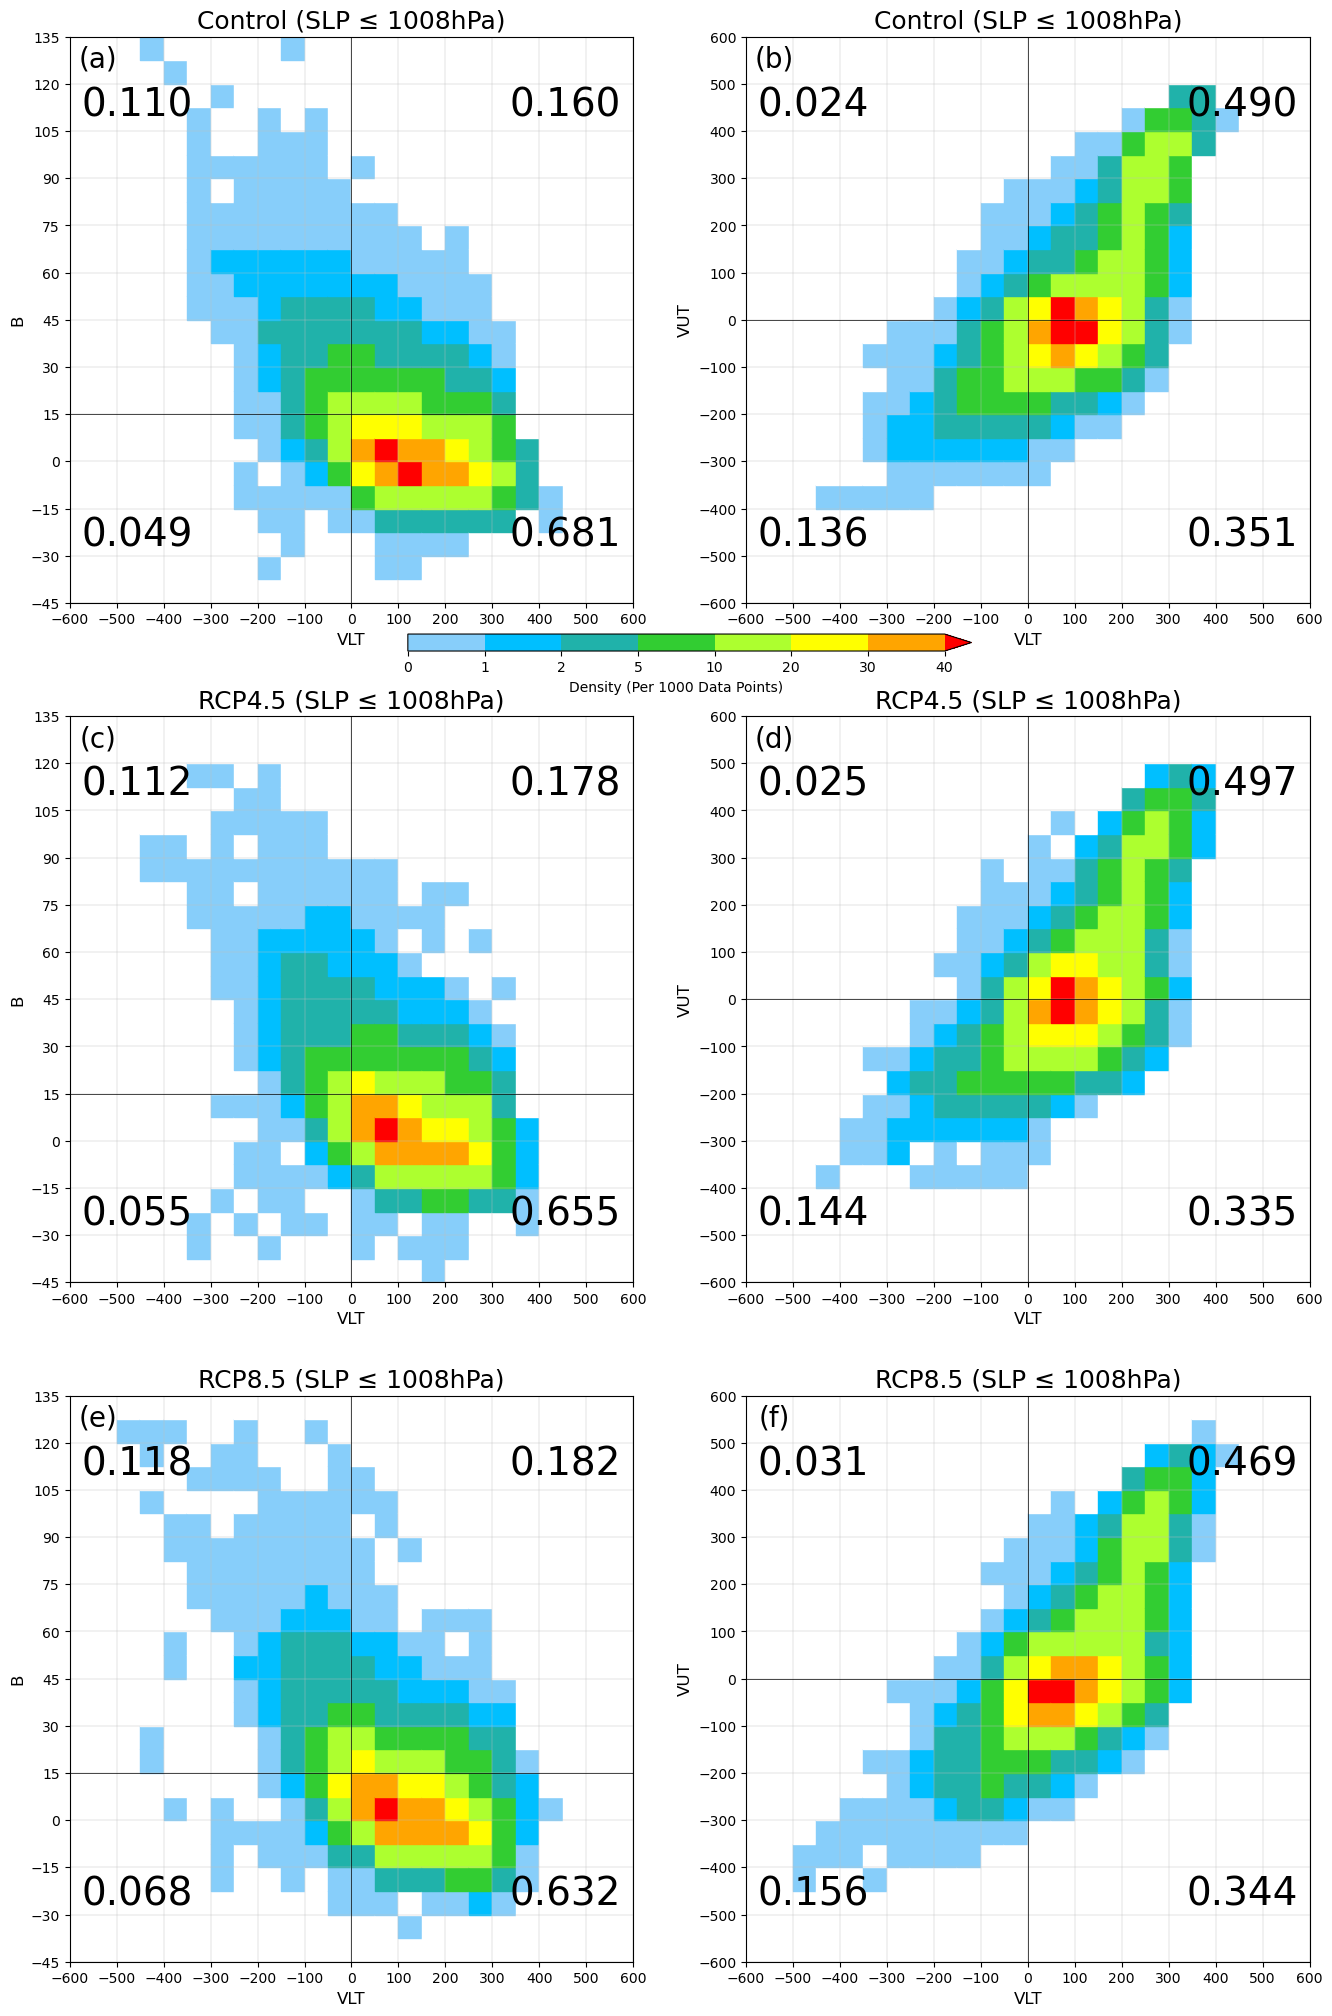

In [21]:
# Plot Phase Space Distributions
Fig = pyplot.figure(figsize=(16,25))
Phase_Distr_Plot(Control_1008hPa, "Control", 0, Distr_Bounds, Distr_Colours, True, "SLP ≤ 1008hPa")
Phase_Distr_Plot(RCP45_1008hPa, "RCP4.5", 1, Distr_Bounds, Distr_Colours, False, "SLP ≤ 1008hPa")
Phase_Distr_Plot(RCP85_1008hPa, "RCP8.5", 2, Distr_Bounds, Distr_Colours, False, "SLP ≤ 1008hPa")
Fig.savefig(Output_Diri+'Phase_Distr_1008hPa.png', bbox_inches='tight')

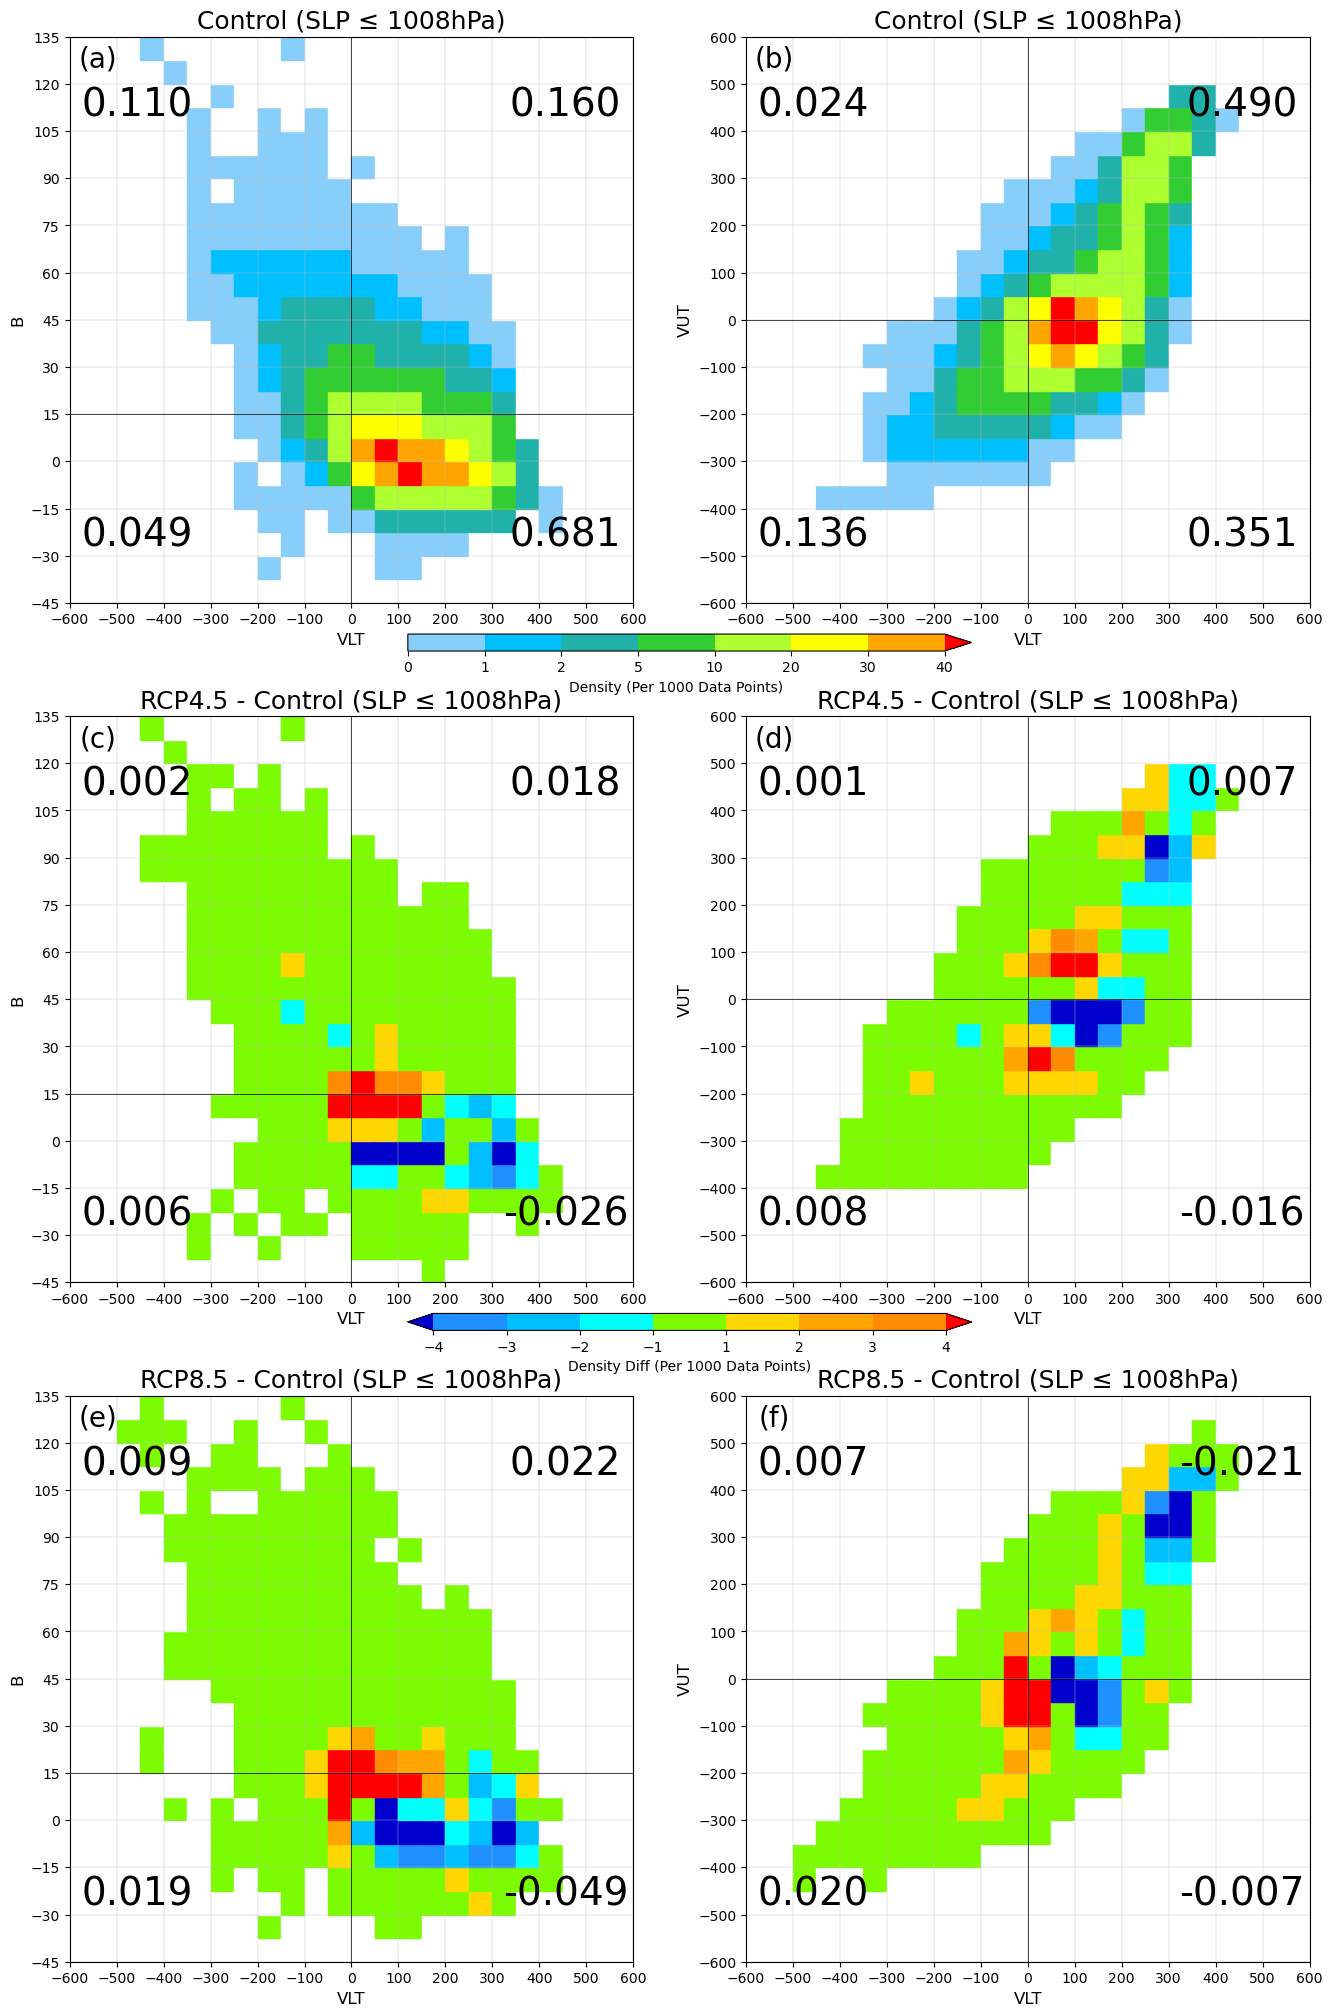

In [22]:
# Plot Differences Between Phase Space Distributions
Fig = pyplot.figure(figsize=(16,25))
Phase_Distr_Plot(Control_1008hPa, "Control", 0, Distr_Bounds, Distr_Colours, True, "SLP ≤ 1008hPa")
Phase_Diff_Plot(RCP45_1008hPa, Control_1008hPa, "RCP4.5", "Control", 1, Diff_Bounds, Diff_Colours, True, "SLP ≤ 1008hPa")
Phase_Diff_Plot(RCP85_1008hPa, Control_1008hPa, "RCP8.5", "Control", 2, Diff_Bounds, Diff_Colours, False, "SLP ≤ 1008hPa")
Fig.savefig(Output_Diri+'Phase_Diff_1008hPa.png', bbox_inches='tight')

In [23]:
# Create Subset of Data: Below 1000hPa
Control_1000hPa = Control_Data[Control_Data["SLP(hPa)"] <= 1000].reset_index()
RCP45_1000hPa = RCP45_Data[RCP45_Data["SLP(hPa)"] <= 1000].reset_index()
RCP85_1000hPa = RCP85_Data[RCP85_Data["SLP(hPa)"] <= 1000].reset_index()

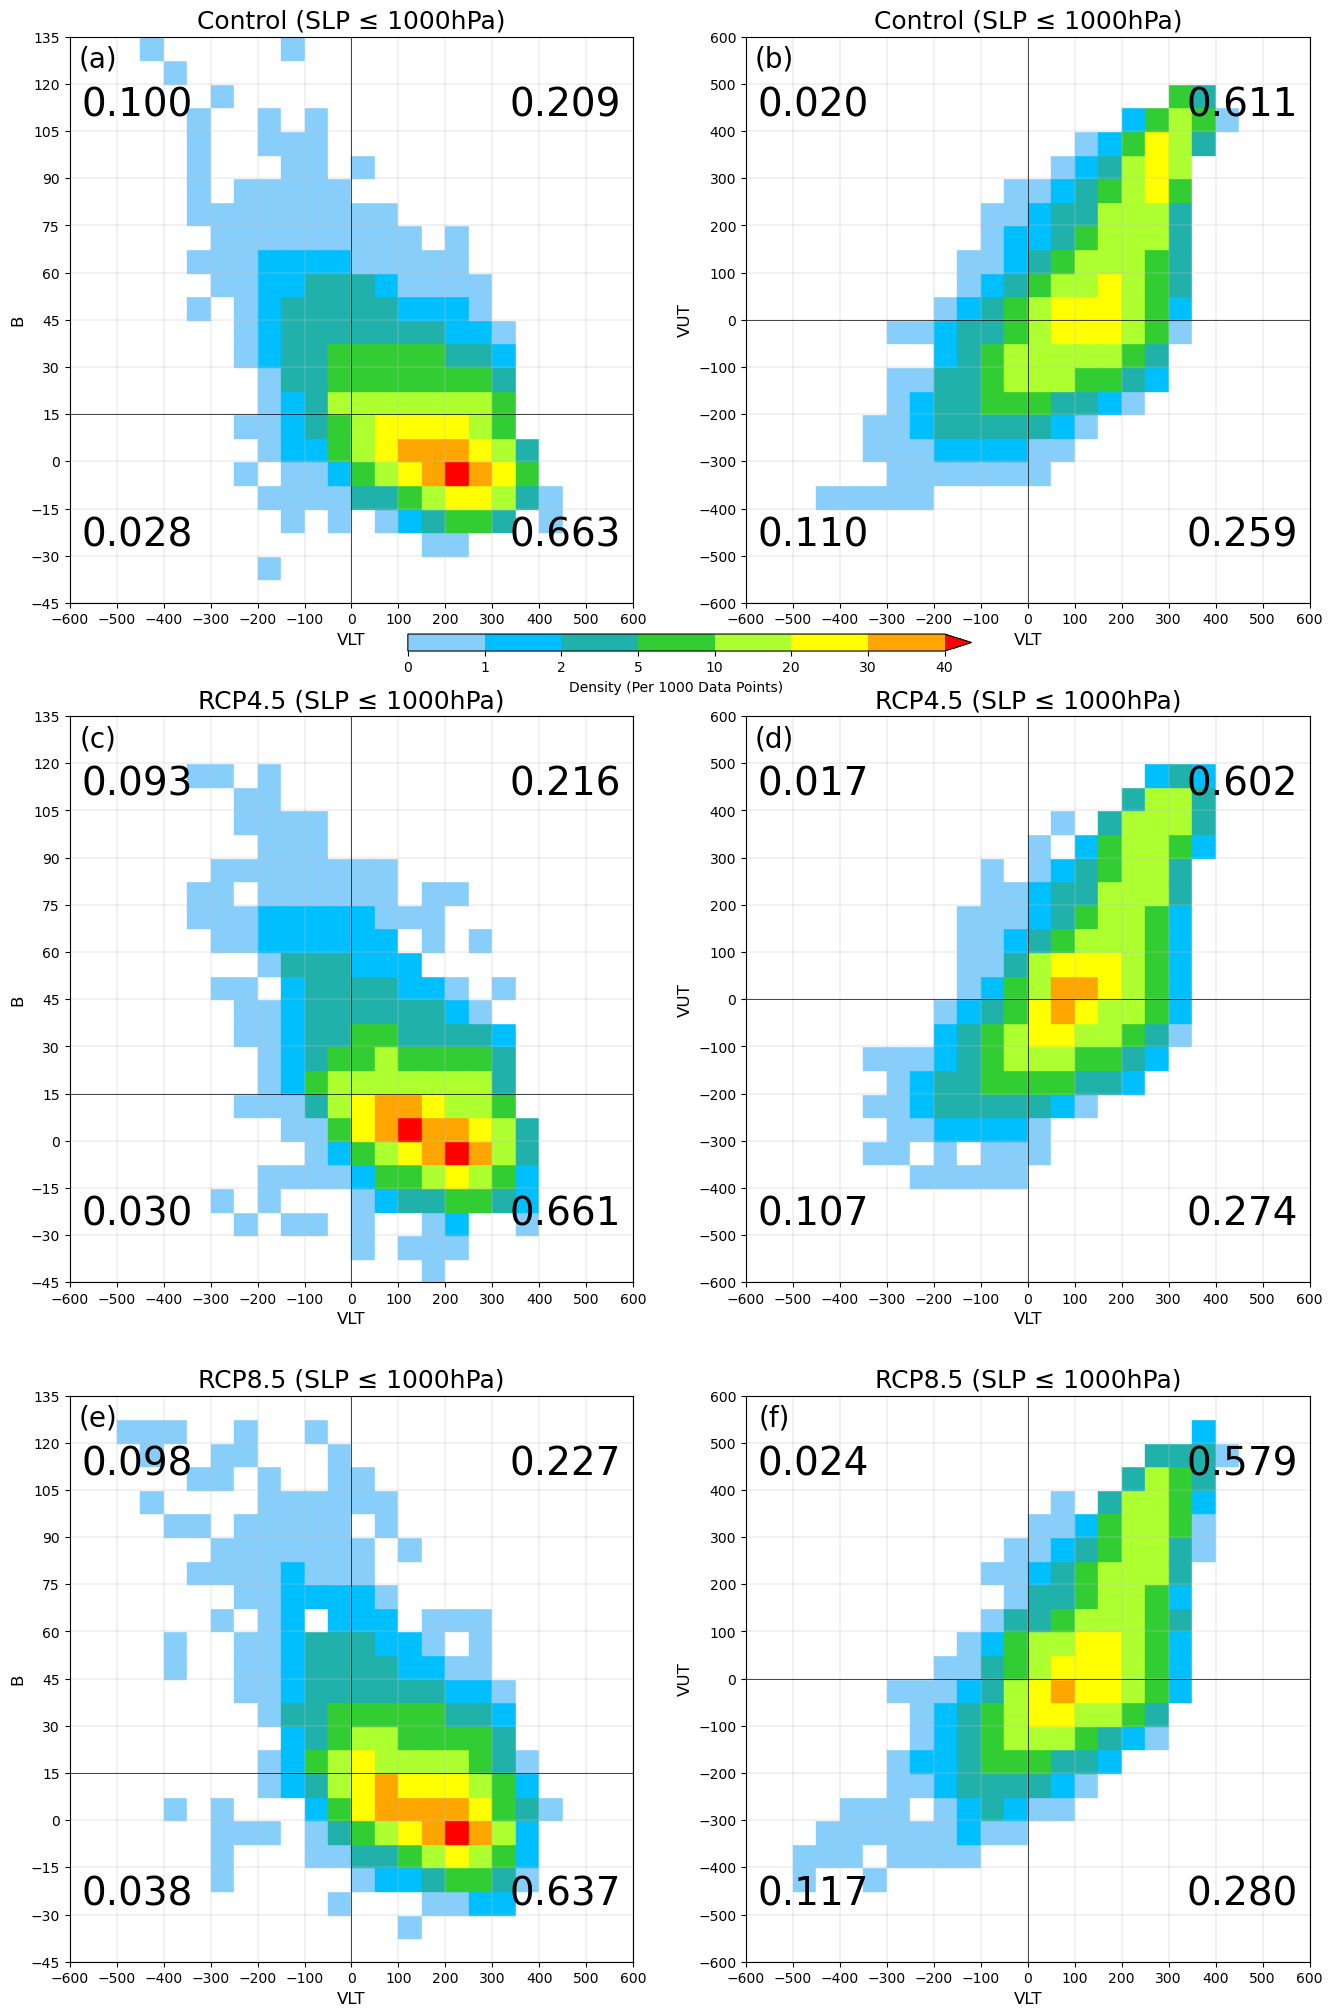

In [24]:
# Plot Phase Space Distributions
Fig = pyplot.figure(figsize=(16,25))
Phase_Distr_Plot(Control_1000hPa, "Control", 0, Distr_Bounds, Distr_Colours, True, "SLP ≤ 1000hPa")
Phase_Distr_Plot(RCP45_1000hPa, "RCP4.5", 1, Distr_Bounds, Distr_Colours, False, "SLP ≤ 1000hPa")
Phase_Distr_Plot(RCP85_1000hPa, "RCP8.5", 2, Distr_Bounds, Distr_Colours, False, "SLP ≤ 1000hPa")
Fig.savefig(Output_Diri+'Phase_Distr_1000hPa.png', bbox_inches='tight')

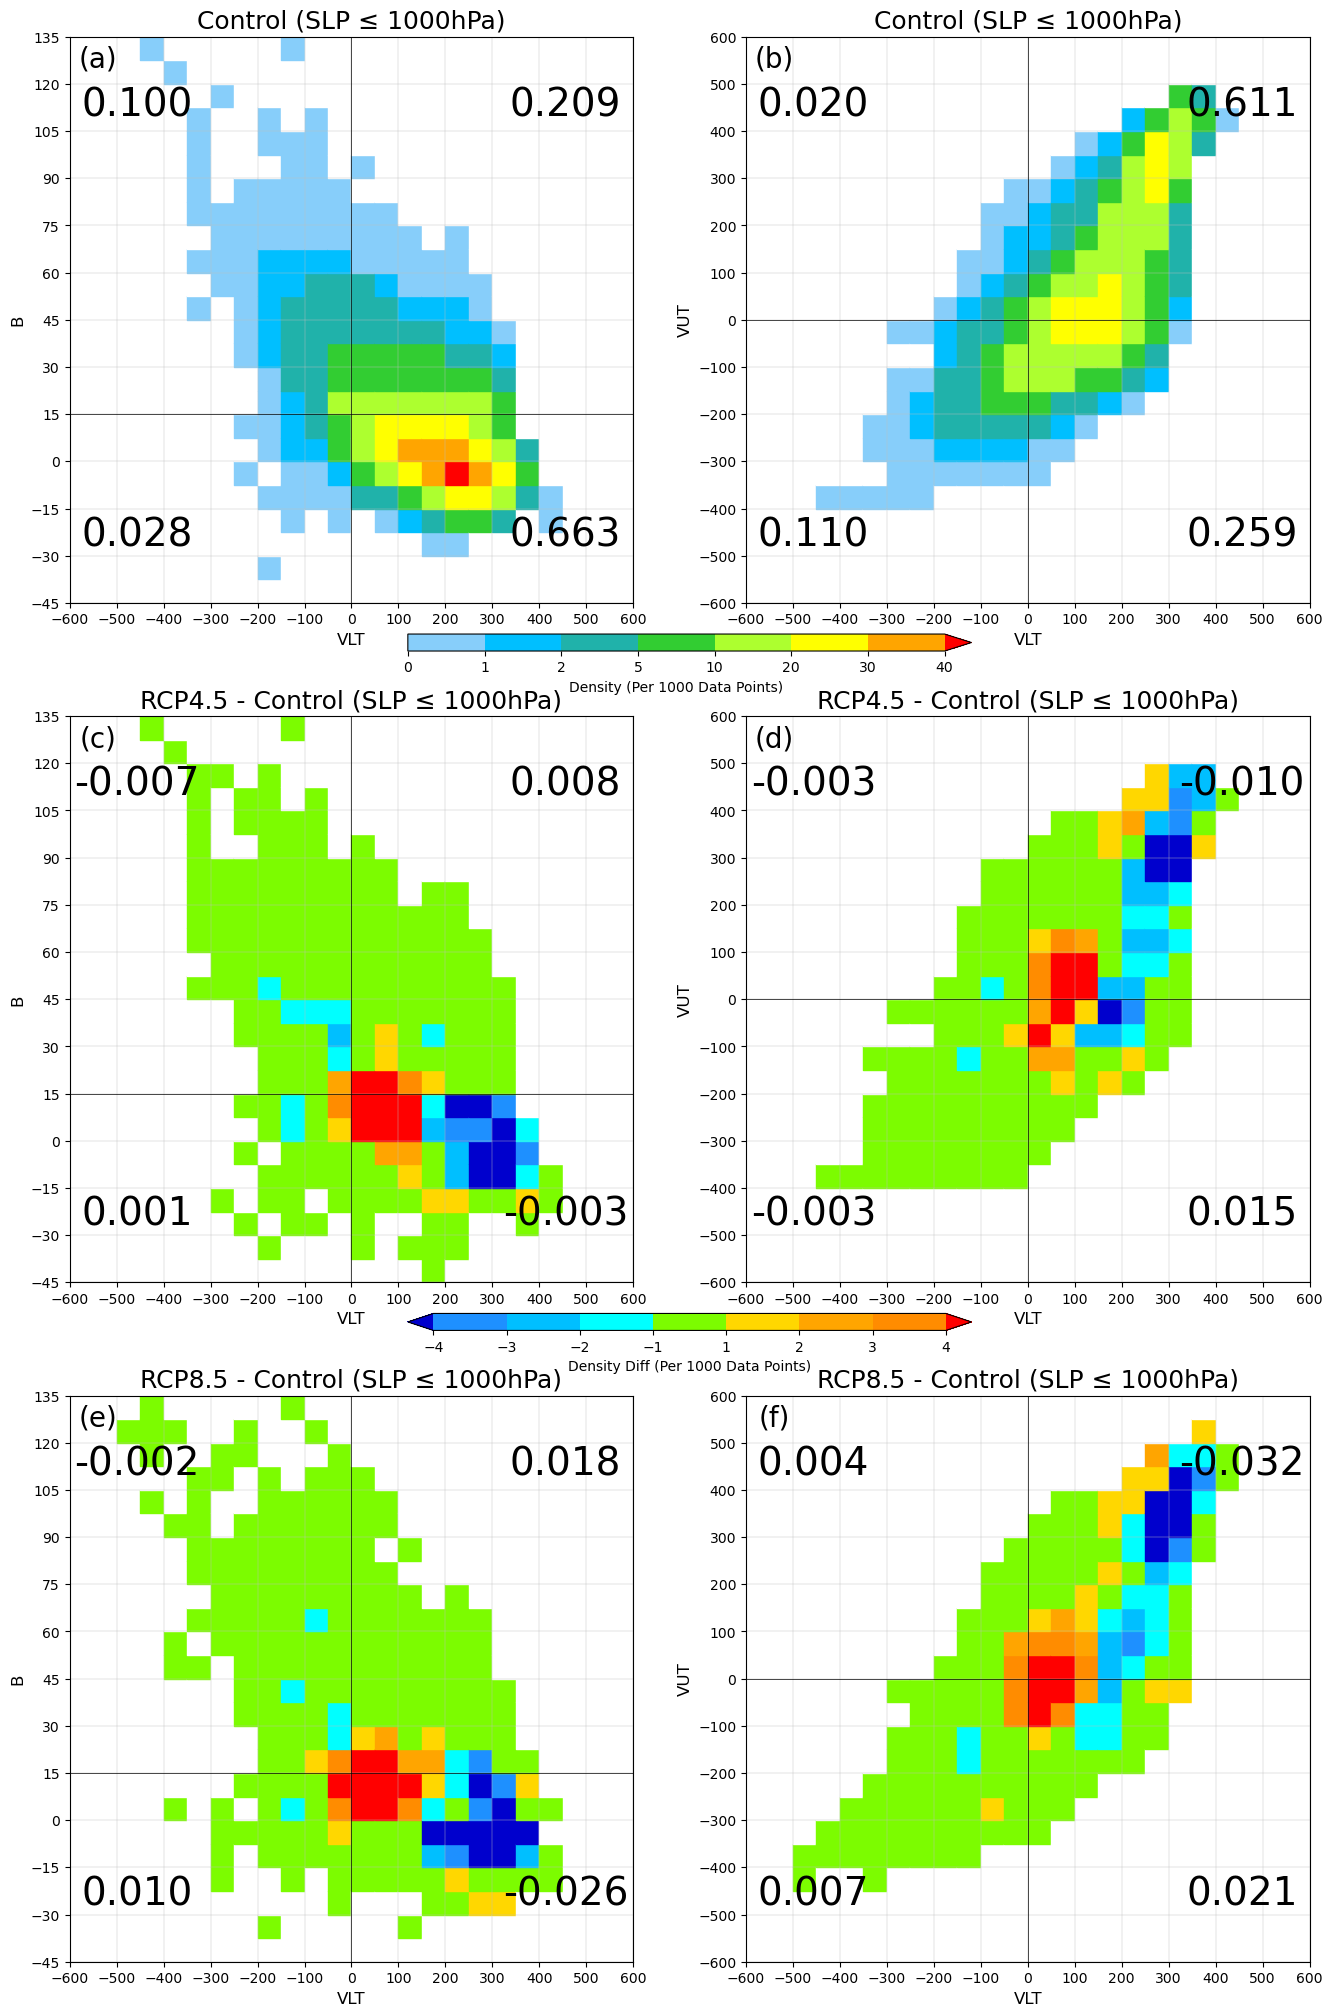

In [25]:
# Plot Differences Between Phase Space Distributions
Fig = pyplot.figure(figsize=(16,25))
Phase_Distr_Plot(Control_1000hPa, "Control", 0, Distr_Bounds, Distr_Colours, True, "SLP ≤ 1000hPa")
Phase_Diff_Plot(RCP45_1000hPa, Control_1000hPa, "RCP4.5", "Control", 1, Diff_Bounds, Diff_Colours, True, "SLP ≤ 1000hPa")
Phase_Diff_Plot(RCP85_1000hPa, Control_1000hPa, "RCP8.5", "Control", 2, Diff_Bounds, Diff_Colours, False, "SLP ≤ 1000hPa")
Fig.savefig(Output_Diri+'Phase_Diff_1000hPa.png', bbox_inches='tight')

In [26]:
# Create Subset of Data: Below 980hPa
Control_980hPa = Control_Data[Control_Data["SLP(hPa)"] <= 980].reset_index()
RCP45_980hPa = RCP45_Data[RCP45_Data["SLP(hPa)"] <= 980].reset_index()
RCP85_980hPa = RCP85_Data[RCP85_Data["SLP(hPa)"] <= 980].reset_index()

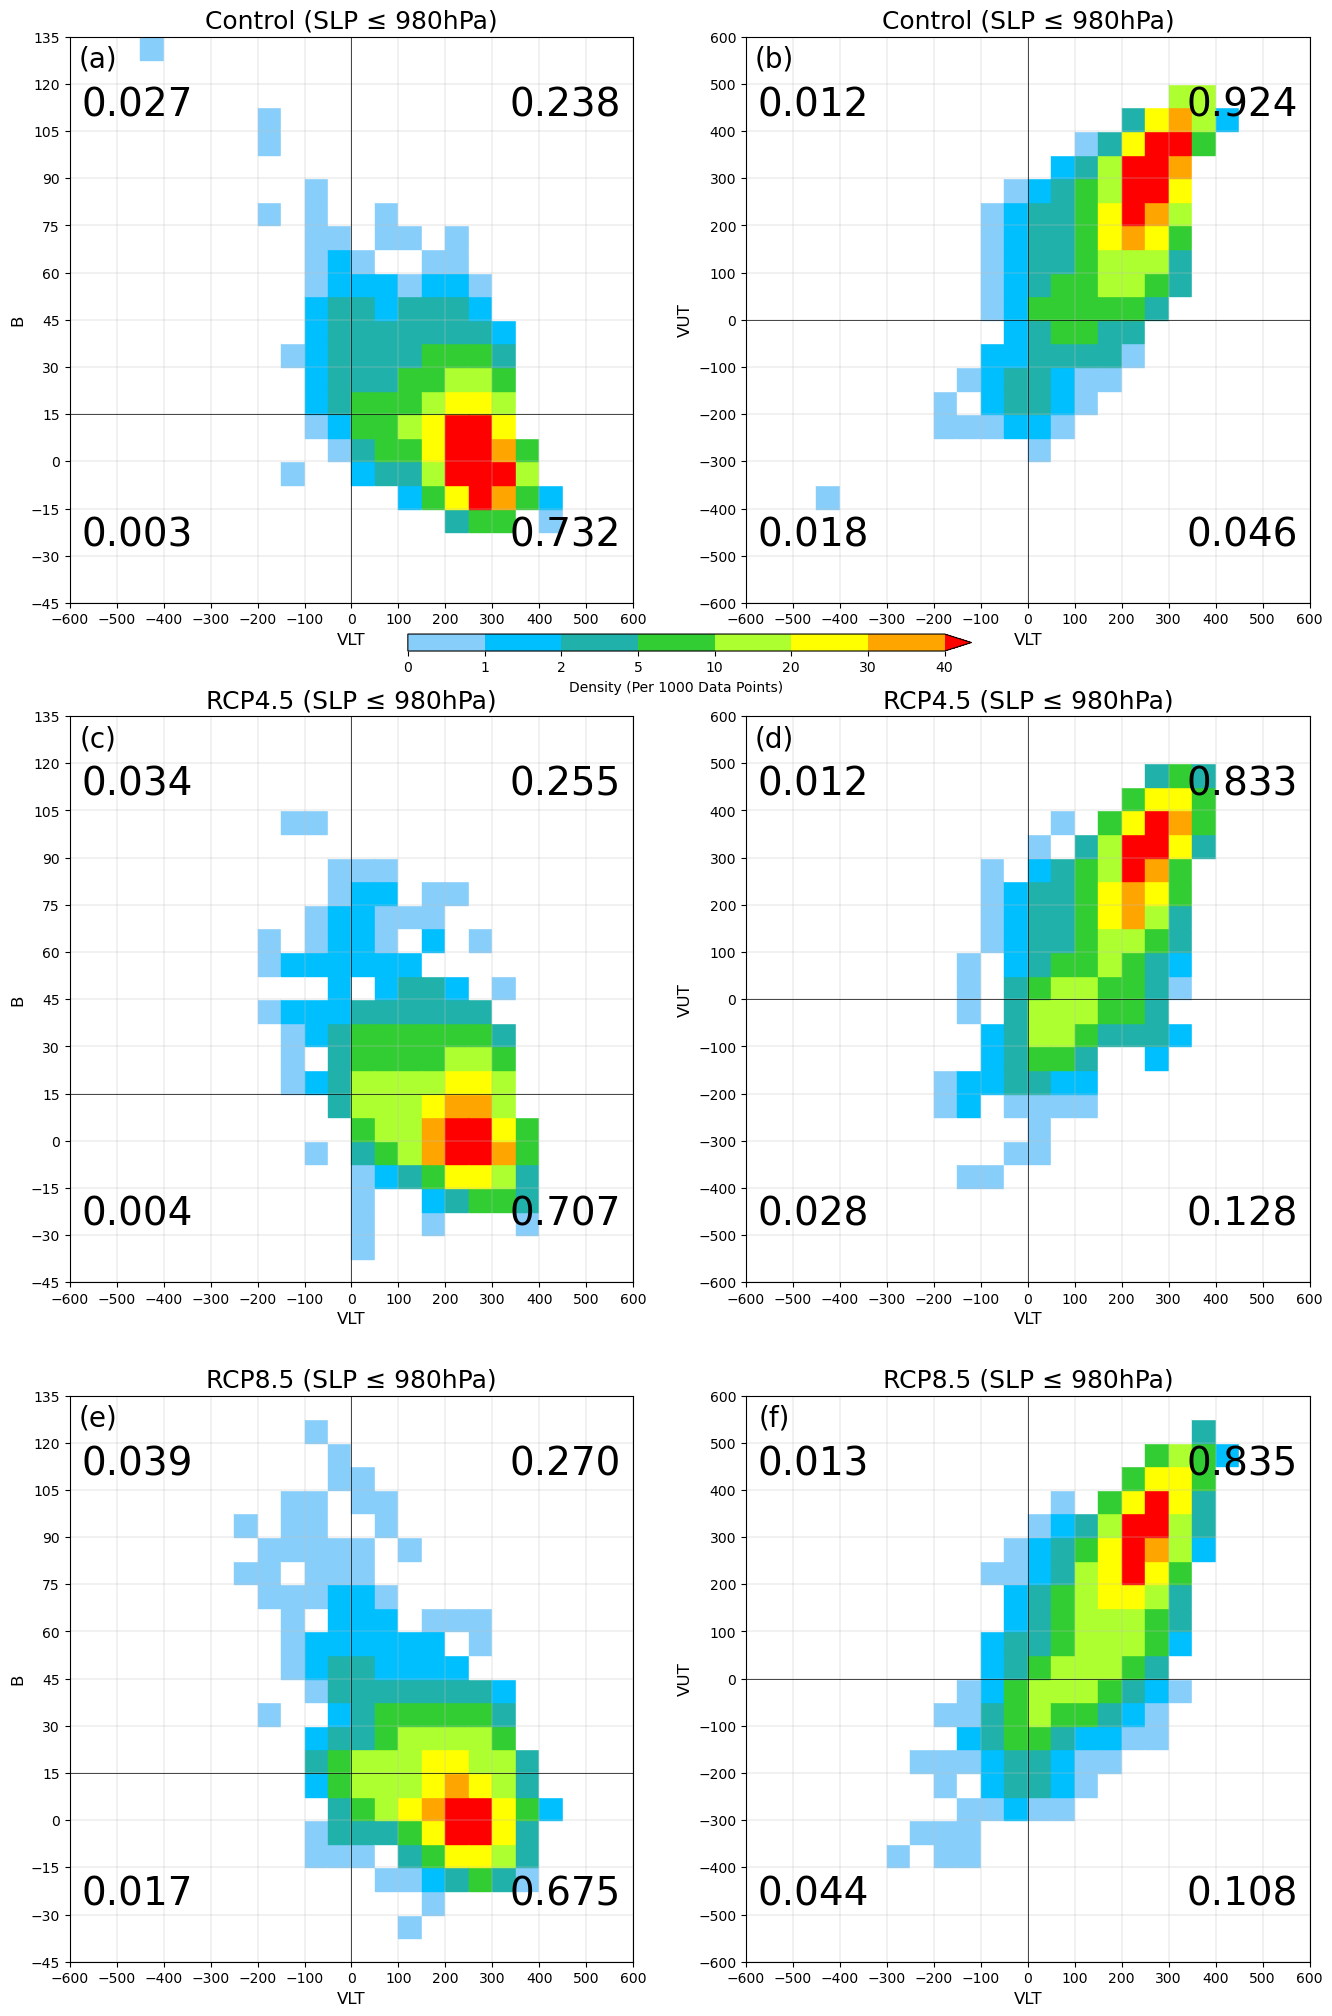

In [27]:
# Plot Phase Space Distributions
Fig = pyplot.figure(figsize=(16,25))
Phase_Distr_Plot(Control_980hPa, "Control", 0, Distr_Bounds, Distr_Colours, True, "SLP ≤ 980hPa")
Phase_Distr_Plot(RCP45_980hPa, "RCP4.5", 1, Distr_Bounds, Distr_Colours, False, "SLP ≤ 980hPa")
Phase_Distr_Plot(RCP85_980hPa, "RCP8.5", 2, Distr_Bounds, Distr_Colours, False, "SLP ≤ 980hPa")
Fig.savefig(Output_Diri+'Phase_Distr_980hPa.png', bbox_inches='tight')

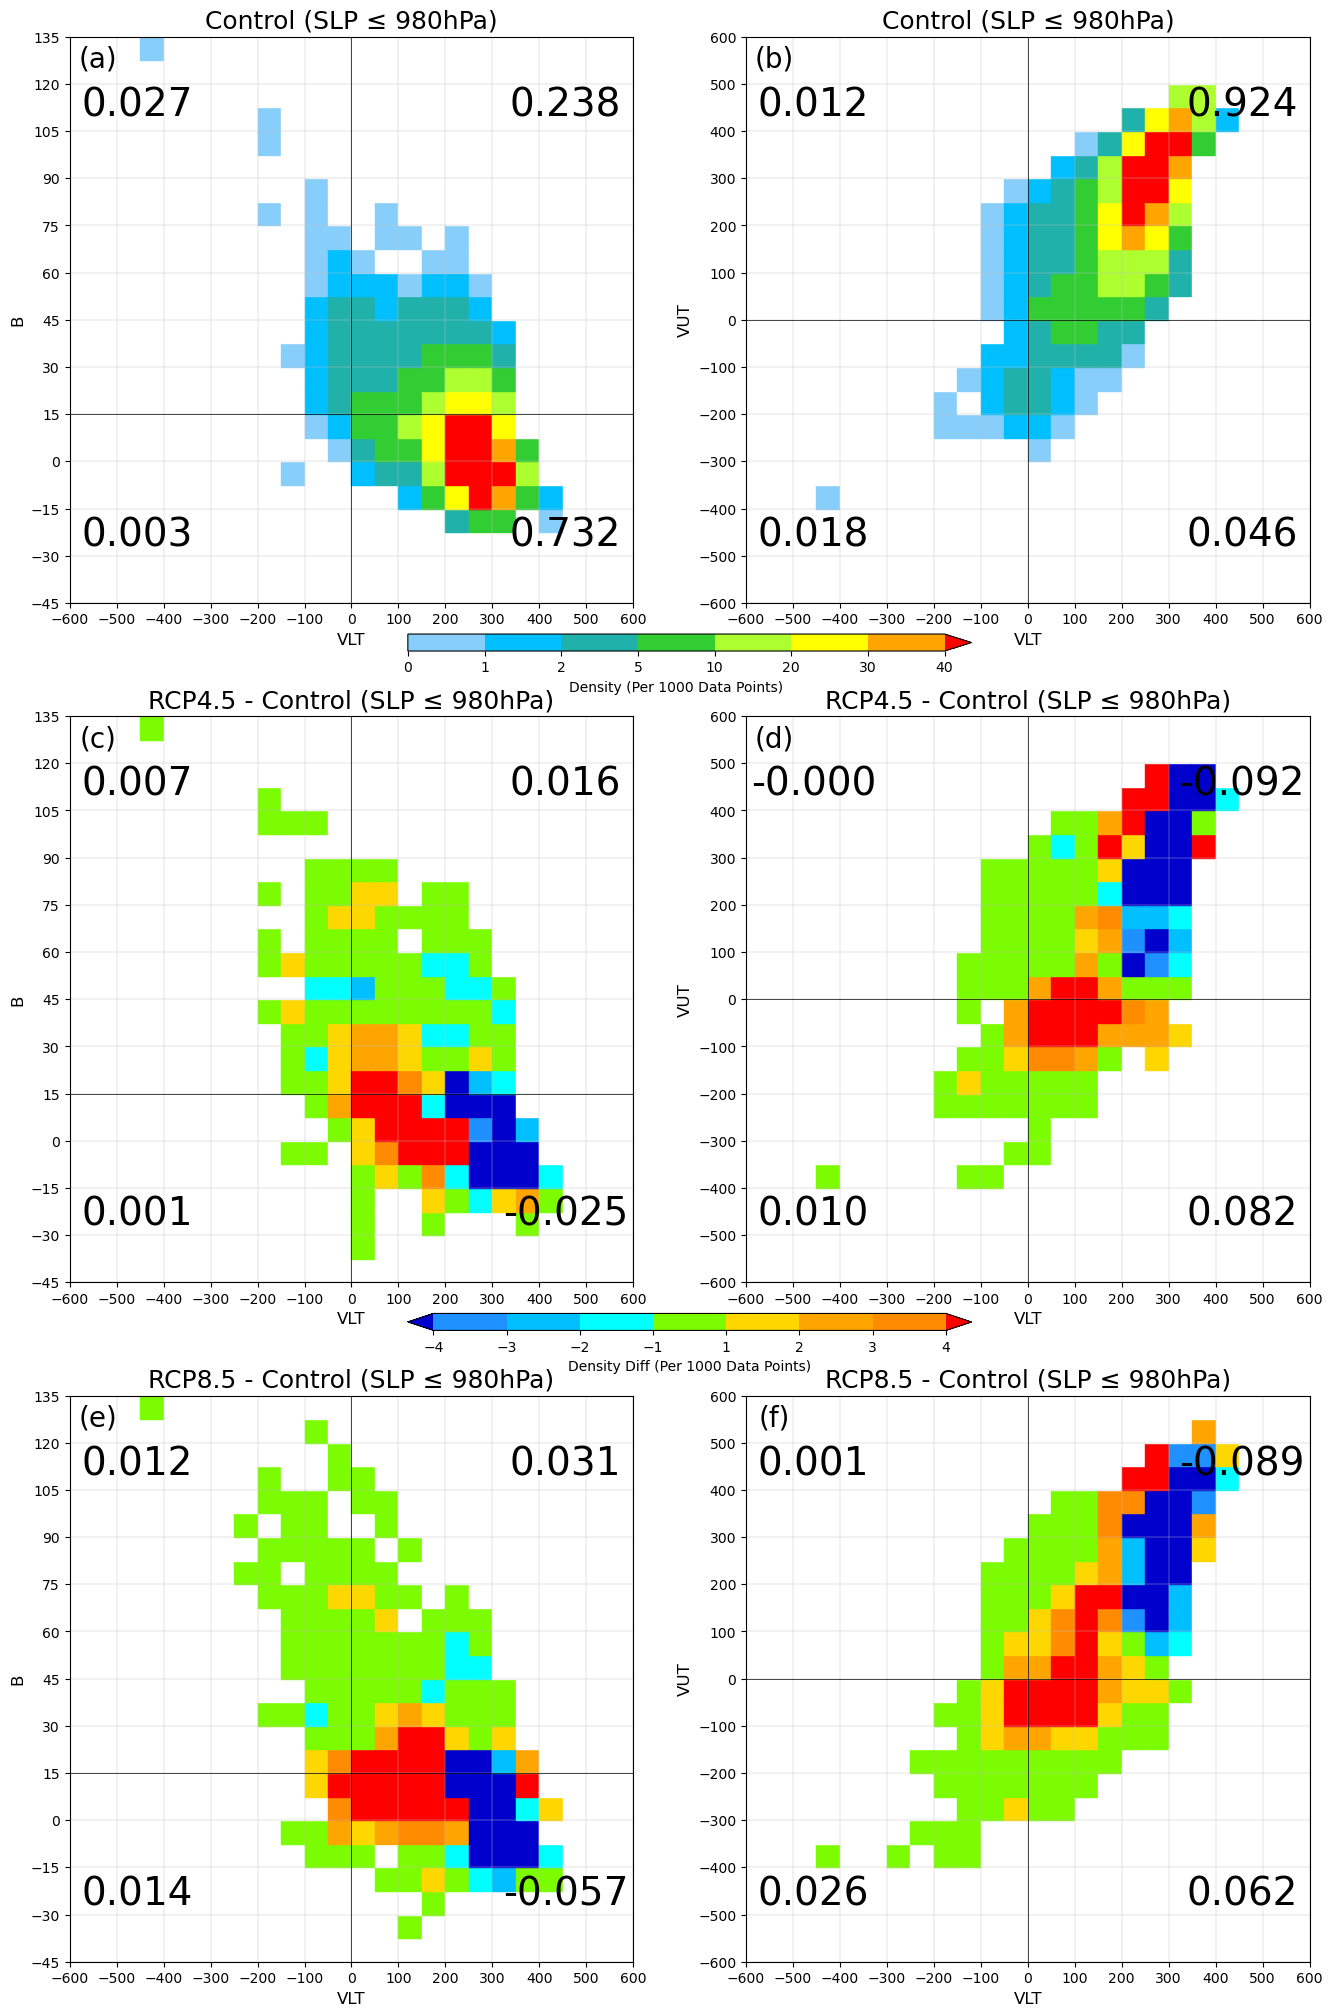

In [28]:
# Plot Differences Between Phase Space Distributions
Fig = pyplot.figure(figsize=(16,25))
Phase_Distr_Plot(Control_980hPa, "Control", 0, Distr_Bounds, Distr_Colours, True, "SLP ≤ 980hPa")
Phase_Diff_Plot(RCP45_980hPa, Control_980hPa, "RCP4.5", "Control", 1, Diff_Bounds, Diff_Colours, True, "SLP ≤ 980hPa")
Phase_Diff_Plot(RCP85_980hPa, Control_980hPa, "RCP8.5", "Control", 2, Diff_Bounds, Diff_Colours, False, "SLP ≤ 980hPa")
Fig.savefig(Output_Diri+'Phase_Diff_980hPa.png', bbox_inches='tight')